In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

In [2]:
# Load preprocessed data
preprocessed_data = pd.read_pickle("preprocessed_data.pkl")
X_scaled = preprocessed_data["X_scaled"]
y_resampled = preprocessed_data["y_resampled"]
class_labels = preprocessed_data["class_labels"]

# Load the original features for feature importance (before scaling and SMOTE)
original_features = pd.read_pickle("original_features.pkl")

In [3]:
sample_sizes = [25, 50, 75, 100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000, 20000, 30000, 40000, 50000]

In [4]:
# Function to create a stratified subsample
def stratified_subsample(X, y, train_size, random_state=42):
    if len(X) < train_size:
        raise ValueError(f"Insufficient data for sample size {train_size}.")
    X_sample, _, y_sample, _ = train_test_split(
        X, y, train_size=train_size, stratify=y, random_state=random_state
    )
    return X_sample, y_sample

In [5]:
X_sample, y_sample = stratified_subsample(X_scaled, y_resampled, train_size=50000)

param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [50, 100, 150],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

# Initialize and run GridSearchCV
grid_search = GridSearchCV(
    estimator=XGBClassifier(
        objective="multi:softprob",
        num_class=len(class_labels),
        eval_metric="mlogloss",
        random_state=42,
    ),
    param_grid=param_grid,
    scoring="accuracy",
    cv=StratifiedKFold(3),
    verbose=2,
    n_jobs=-1,
)

grid_search.fit(X_sample, y_sample)

# Extract the best parameters
best_params = grid_search.best_params_
print("Best Parameters Found by GridSearchCV:")
print(best_params)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters Found by GridSearchCV:
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.6}


In [6]:
results = {}
for sample_size in sample_sizes:
    try:
        X_sampled, y_sampled = stratified_subsample(X_scaled, y_resampled, sample_size)
        
        test_size = max(0.2, len(class_labels) / len(y_sampled))
        stratify = y_sampled if len(y_sampled) >= len(class_labels) else None

        X_train, X_test, y_train, y_test = train_test_split(
            X_sampled, y_sampled, test_size=0.2, stratify=y_sampled, random_state=42
        )

        # Use the best parameters for training
        xgb_model = XGBClassifier(
            **best_params,
            objective="multi:softprob",
            num_class=len(class_labels),
            eval_metric="mlogloss",
            random_state=42,
        )
        xgb_model.fit(X_train, y_train)

        y_pred = xgb_model.predict(X_test)
        print(f"Classification Report for Sample Size {sample_size}:\n")
        print(classification_report(y_test, y_pred, target_names=class_labels))
        # Save results, plot confusion matrix, etc.

    except ValueError as e:
        print(f"Skipping sample size {sample_size}: {e}")

Skipping sample size 25: The test_size = 5 should be greater or equal to the number of classes = 11
Skipping sample size 50: The test_size = 10 should be greater or equal to the number of classes = 11
Classification Report for Sample Size 75:

                                      precision    recall  f1-score   support

                             Anaemia       0.33      1.00      0.50         1
                          Arrhythmia       0.00      0.00      0.00         1
                     Atherosclerosis       0.00      0.00      0.00         2
               Autonomic Dysfunction       0.00      0.00      0.00         1
        Cardiovascular Disease (CVD)       1.00      0.50      0.67         2
      Chronic Fatigue Syndrome (CFS)       0.33      0.50      0.40         2
                            Diabetes       1.00      1.00      1.00         1
                             Healthy       0.50      1.00      0.67         1
                        Hypertension       0.00      

c:\Users\TMRND\miniconda3\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\TMRND\miniconda3\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\TMRND\miniconda3\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report for Sample Size 100:

                                      precision    recall  f1-score   support

                             Anaemia       1.00      0.50      0.67         2
                          Arrhythmia       0.50      1.00      0.67         1
                     Atherosclerosis       0.00      0.00      0.00         2
               Autonomic Dysfunction       1.00      0.50      0.67         2
        Cardiovascular Disease (CVD)       1.00      1.00      1.00         2
      Chronic Fatigue Syndrome (CFS)       0.50      0.50      0.50         2
                            Diabetes       0.00      0.00      0.00         2
                             Healthy       0.67      1.00      0.80         2
                        Hypertension       0.33      0.50      0.40         2
Respiratory Disease (COPD or Asthma)       0.25      1.00      0.40         1
            Stress-related Disorders       0.00      0.00      0.00         2

                  

c:\Users\TMRND\miniconda3\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\TMRND\miniconda3\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\TMRND\miniconda3\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report for Sample Size 250:

                                      precision    recall  f1-score   support

                             Anaemia       1.00      1.00      1.00         5
                          Arrhythmia       0.40      1.00      0.57         4
                     Atherosclerosis       0.80      0.80      0.80         5
               Autonomic Dysfunction       1.00      1.00      1.00         4
        Cardiovascular Disease (CVD)       1.00      0.75      0.86         4
      Chronic Fatigue Syndrome (CFS)       1.00      0.80      0.89         5
                            Diabetes       1.00      0.75      0.86         4
                             Healthy       1.00      1.00      1.00         4
                        Hypertension       0.75      0.60      0.67         5
Respiratory Disease (COPD or Asthma)       0.80      0.80      0.80         5
            Stress-related Disorders       0.67      0.40      0.50         5

                  

In [7]:
# Save the model
xgb_model.save_model("xgboost_model.json")

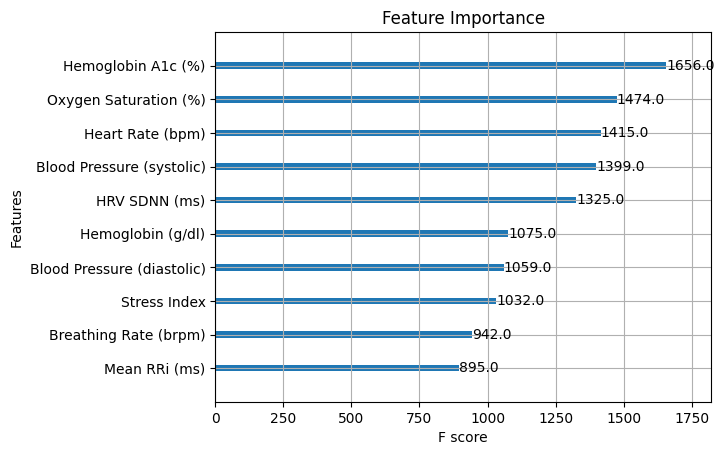

Feature Importance Mapping:
Heart Rate (bpm): 0.047179680317640305
Breathing Rate (brpm): 0.03485385328531265
Oxygen Saturation (%): 0.1198473796248436
Blood Pressure (systolic): 0.03881039470434189
Blood Pressure (diastolic): 0.03480289503931999
Stress Index: 0.09208237379789352
Recovery Ability: 0.11224678158760071
PNS Index: 0.07172395288944244
SNS Index: 0.01812220923602581
RMSSD (ms): 0.011320679448544979
SD2 (ms): 0.01320706307888031
Hemoglobin A1c (%): 0.14210446178913116
Mean RRi (ms): 0.09132708609104156
SD1 (ms): 0.02253888174891472
HRV SDNN (ms): 0.07342927157878876
Hemoglobin (g/dl): 0.07640302181243896


In [8]:
# Feature importance analysis
plot_importance(xgb_model, max_num_features=10)
plt.title("Feature Importance")
plt.show()

# Map feature names to importance values
feature_importances = xgb_model.feature_importances_
feature_mapping = {f"f{i}": col for i, col in enumerate(original_features.columns)}
importance_mapping = {
    feature_mapping[f"f{i}"]: importance
    for i, importance in enumerate(feature_importances)
}
print("Feature Importance Mapping:")
for feature, importance in importance_mapping.items():
    print(f"{feature}: {importance}")